In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
import subprocess
from tqdm import tqdm

import sys
sys.path.append('../core')
sys.path.append('../../Psi_to_q/core')

from Psi_gen import Psi_gen
from LSTM_ROM import LSTM_ROM
from Psi_to_q_net import Psi_to_q_net

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # comment to use GPU

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load model for Xi to q without forecast
Q = Psi_to_q_net(restart_file='../../Psi_to_q/saved_models/Psi_q_NN_tau0.0.npy')

# Load LSTM dynamic model for Xi
H = LSTM_ROM(restart_file='../saved_models/Psi_ROM_32.npy')

# Load Psi from file to get normalization used by LSTM model
Psi = np.load('../../P_to_Psi/dense_Psi_predictions/Psi_32.npy', allow_pickle=True).item()['Psi']
Psi_mean = np.mean(Psi, axis=0)
Psi_std = np.std(Psi, axis=0)

# Set up data generator
r = 32
n_steps = 350
batch_size = 500
m_hist = 70
stride = 3

t = 0.01*stride*np.arange(n_steps+1)
gen = Psi_gen(r, n_steps, batch_size, m_hist, stride, return_q=True)

In [3]:
if False:

    Error = []
    Q_Error = []
    n_batches = gen.test_batches

    for batch in tqdm(range(n_batches)):

        Xi_hist, Xi_forecast, Q_true, batch_inds = gen.next_test(return_inds=True)
        Q_error_init = gen.q[batch_inds].reshape(len(batch_inds),1) - Q.network(Xi_hist[:,-1,:]*Psi_std + Psi_mean).numpy()
        Xi_est = []

        for step in range(n_steps):
            Xi_est.append(tf.expand_dims(H.network(Xi_hist), axis=1))
            Xi_hist = tf.concat([Xi_hist[:,1:,:], Xi_est[-1]], axis=1)

        Xi_est = tf.concat(Xi_est,axis=1).numpy()
        Q_est = np.hstack([Q.network(Xi_est[:,j,:]*Psi_std + Psi_mean).numpy() for j in range(n_steps)])

        Error.append(np.hstack([np.zeros((len(batch_inds),1,32)), Xi_forecast - Xi_est]))
        Q_Error.append(np.hstack([Q_error_init, Q_true - Q_est]))

    error = np.vstack(Error)
    q_error = np.vstack(Q_Error)
    
    error_dict = {'Psi_error' : error, 'q_error' : q_error}
    np.save('Psi_ROM_32_error', error_dict)
    
else:
    
    error_dict = np.load('Psi_ROM_32_error.npy',allow_pickle=True).item()
    error = error_dict['Psi_error']
    q_error = error_dict['q_error']

In [4]:
mse_ind = np.linalg.norm(error,axis=2)**2 / error.shape[2]
mse_batch = np.linalg.norm(error,axis=0)**2 / error.shape[0]

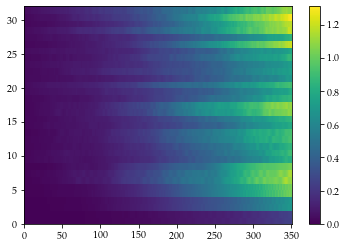

In [5]:
pcolor(mse_batch.T)
colorbar()

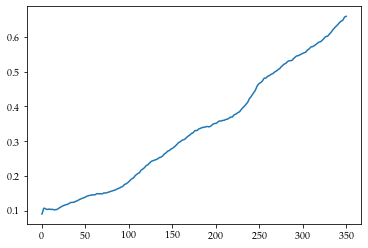

In [6]:
plot(np.mean(np.abs(q_error),axis=0))

(0.0, 10.5)

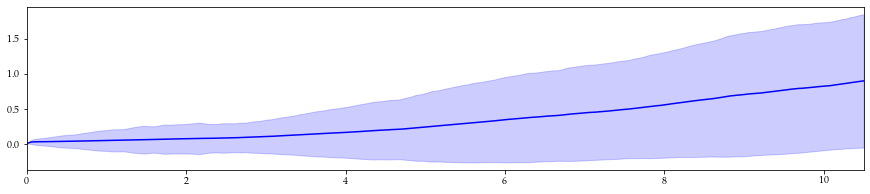

In [7]:
figure(figsize = (15,3))
plot(t,np.mean(mse_ind,axis=0), color='b')
fill_between(t,np.mean(mse_ind,axis=0)-np.std(mse_ind,axis=0),
     np.mean(mse_ind,axis=0)+np.std(mse_ind,axis=0), color='b', alpha=0.2)
xlim([t[0],t[-1]])

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  import sys
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


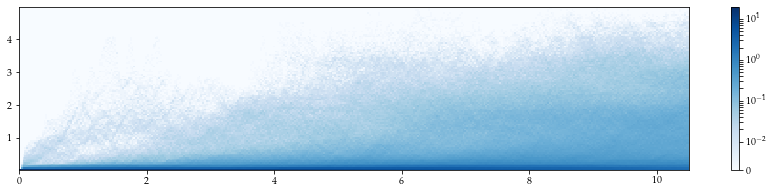

In [8]:
figure(figsize = (15,3))
nbins = 100
x = np.linspace(0,5,nbins); dx = x[1]-x[0]
error_hist = np.stack([np.histogram(mse_ind[:,i],bins=x,density=True)[0] for i in range(n_steps)],axis=1)
pcolor(t,(x[1:]+x[:-1])/2, error_hist, shading='auto', cmap='Blues',  
       norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1,
                                         vmin=0, vmax=np.max(error_hist)))
colorbar()

/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  
/home/samuel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


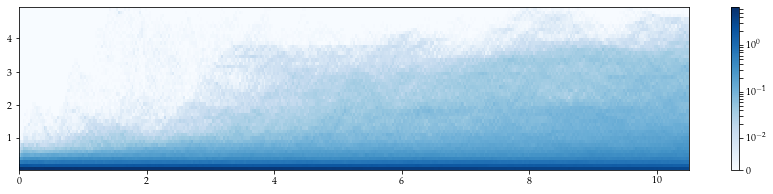

In [9]:
x = np.linspace(0,5,50)
error_hist = np.stack([np.histogram(np.abs(q_error[:,i]),bins=x,density=True)[0] for i in range(n_steps)],axis=1)
figure(figsize = (15,3))
pcolor(t,(x[1:]+x[:-1])/2, error_hist, shading='auto', cmap='Blues', 
       norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1,
                                         vmin=0, vmax=np.max(error_hist)))
colorbar()